# Grade: /100 pts

# Assignment 05: Model Selection & Cross Validation

### Dear Applicant...You've Been Invited To  Interview To Be A Data Scientist!

You've been invited to interview for a Junior Data Scientist job for a consulting firm. This company works with a variety of machine learning applications from banking to sports!.

You will face one important task: *Advice a bank. Constructing a model for predicting the probability of retail products default.*

The bank has provided you with data for 1000 loans.  Your job: build a model or models, perform model selection using cross validation techniques, and evaluate your final selected model.

### The Dataset

The data is stored in a csv file called `loan_Data.csv`.  The data includes some information about the payment behavior and customer characteristics such  as job and purpose acquiring the current loan. You could view the dictionary of the variables given in the file `loan_param.xlsx)`.

The target variable is `loanDefault`, which takes the categories Fully Paid or Charged Off.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline. 

5.  Your submission document should be saved in the form: `LastName_FirstName_Assignment5.ipynb`

---

In [543]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer, mean_squared_error,roc_curve, auc, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin

pd.set_option('display.max_columns', 500)

%matplotlib inline

%matplotlib inline
plt.style.use('ggplot')


_____

### Question 1: /10pts

As the initial step, the hiring manager asks you to load the data `loan_Data.csv` and identify the last 5 rows of the data (observe that the rows have been shuffled).
Since you are going to create a predictive model for the default probability the hiring manager is expecting you to change the values of the column `loanDefault` to 1 if the loan is `Charged Off` and 0 if it is `Fully Paid`. 

In [544]:
# Upload the data
Data1 = pd.read_csv('loan_Data.csv',sep=';')

# Shuffle the rows
Data1 = Data1.sample(frac=1, random_state=0)

# Print the last 5 rows
Data1.tail()

#2 pts

,loanAmnt,annualInc,application_type,int_rate,revol_bal,revol_util,dti,emp_length,grade,homeOwnership,installment,job,loanDefault,mortAcc,pub_rec_bankruptcies,purpose,term,Year
835,25000.0,112000.0,INDIVIDUAL,11.99,42261.0,70.7,11.14,10,B,MORTGAGE,830.24,VP dealer relations,Fully Paid,10,0,debt_consolidation,36,2015
192,30000.0,101000.0,INDIVIDUAL,19.52,16300.0,48.7,19.88,7,E,MORTGAGE,786.83,cbp officer,Fully Paid,13,0,debt_consolidation,60,2015
629,17000.0,73000.0,INDIVIDUAL,13.11,27909.0,66.3,29.00,2,B,RENT,573.70,HCA,Fully Paid,14,0,debt_consolidation,36,2013
559,15600.0,67500.0,INDIVIDUAL,7.39,16146.0,43.9,14.29,4,A,RENT,484.47,Senior associatw,Fully Paid,15,0,debt_consolidation,36,2016
684,10000.0,70000.0,INDIVIDUAL,22.15,6475.0,75.3,12.62,2,E,RENT,382.69,Account Managet,Charged Off,7,0,moving,36,2014


In [545]:
# Change loanDefault variable as binary
Data1['loanDefault'] = Data1['loanDefault'].replace(['Fully Paid','Charged Off'],[0,1])

# 2 pts

In [546]:
# Print the dimension of Data1
Data1.info()
# 1pt

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 993 to 684
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loanAmnt              1000 non-null   float64
 1   annualInc             1000 non-null   float64
 2   application_type      1000 non-null   object 
 3   int_rate              1000 non-null   float64
 4   revol_bal             1000 non-null   float64
 5   revol_util            1000 non-null   float64
 6   dti                   1000 non-null   float64
 7   emp_length            1000 non-null   int64  
 8   grade                 1000 non-null   object 
 9   homeOwnership         1000 non-null   object 
 10  installment           1000 non-null   float64
 11  job                   1000 non-null   object 
 12  loanDefault           1000 non-null   int64  
 13  mortAcc               1000 non-null   int64  
 14  pub_rec_bankruptcies  1000 non-null   int64  
 15  purpose             

How many observations and columns does this data set have?

**ANSWER HERE:**[1pt] \
This data set has 1000 observations and 18 columns in total. 

Finally create a barchart with the the number of loans in default and non-default.

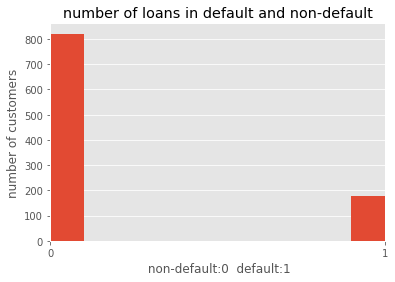

In [547]:
# Code to construct the bartchart 
ax = Data1.loanDefault.plot.hist(title='number of loans in default and non-default')
plt.xlabel(' non-default:0  default:1')
plt.ylabel('number of customers')
plt.xticks((0,1))
plt.xlim([0,1])
plt.show()

# 1pt

In [548]:
# Calculate the percentage of defaulters
dfters = Data1.loanDefault[Data1.loanDefault==1].count()
nondfters = Data1.loanDefault[Data1.loanDefault==0].count()
percentage = dfters/(dfters+nondfters)
print(percentage)
# 1pt

0.179


What is the percentage of defaulters in the data set?

**ANSWER HERE**[1pt] \
The percentage of defaulter in the data set is 17.9%.

_____________

### Question 2: /10pts

The hiring manager is surprised about the proportion of defaulters at the bank. You are asked to determine, using exploratory analysis, if the distribution of income is different between applicants who defaulted and applicants who did not default on their loans.

#### 1 First, construct the histogram of the annual income for all the customers (Do not forget the labels in the axes)

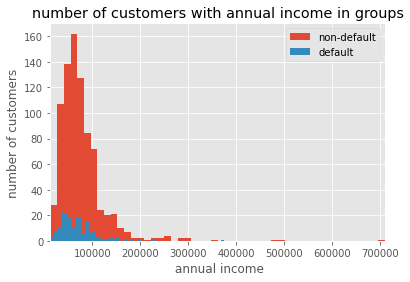

In [549]:
#Code to construct the histogram
Data1.annualInc.groupby(Data1['loanDefault']).plot.hist(bins=50, title='number of customers with annual income in groups' )
plt.xlabel(' annual income')
plt.ylabel('number of customers')
plt.xlim([min(Data1.annualInc),max(Data1.annualInc)])
plt.legend(['non-default','default'])
plt.show()
# 1pt

What do you notice about the distribution of the annual income variable?

**ANSWER HERE**[1pt] \
The most annaul income is under 100,000 and there are almost 700 customers are in this range. There is very less data in the high income range. The data are gathered in the 0-100000 range.

#### 2. You notice the characteristics of the annual income distribution. You remember from your DS 3000's assignment 5 that using a logarithmic transform is a good idea in those cases. Apply a logarithmic transform to the data and plot the new histogram. What do you observe?  Are there differences in the annual income between applicants who defaulted and applicants who did not default in their loans? 


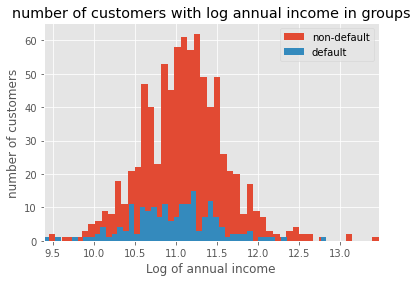

In [550]:
#Code to construct the histogram
Data1['Log_annualInc'] = np.log(Data1['annualInc'])
Data1.Log_annualInc.groupby(Data1['loanDefault']).plot.hist(bins=50, title='number of customers with log annual income in groups')
plt.xlabel('Log of annual income')
plt.ylabel('number of customers')
plt.xlim([min(Data1.Log_annualInc),max(Data1.Log_annualInc)])
plt.legend(['non-default','default'])
plt.show()

# 6pts

**ANSWER HERE**[2pts]  \
The data becomes more normal as they spread out from the center. There is not a lot difference in distibution of the annual income between applicants with defaulted and non-defaulted loans. Both type of the applicants have same spread out in annual income according to the histogram.


___________

### Question 3: /10

The manager told you that the bank has a baseline model for predicting the default probability that consists of a standard logistic regression model with only one feature as the predictor.

You are told the predictor variable is the ratio between the yearly payment owed by the borrower and the annual income. You define this new variable as **ratio_inst_inc** column in your data set.

In [551]:
# Create the new variable ratio_inst_inc, remember the variable installment is given as a monthly payment
Data1.insert(18,column='ratio_inst_inc', value=Data1['installment']*12/Data1['annualInc'])

# 1 pts

Create a basic logistic regression model (with default penalization) named `model_single`. The manager wants you to create a model pipeline to be fit later. (Use `solver='lbfgs'`, `max_iter=10000` and `random_state=0`)

In [552]:
model1 = Pipeline([
    ('model_single',LogisticRegression(solver='lbfgs',max_iter=10000, random_state=0))
])
#1 pt

Now that you have created the pipeline, fit `model1` for predicting the loan default with only one feature: `ratio_inst_inc`. Use a 70/30 train-test split of the data, remember to set `random_state=0` in the function `train_test_split`. After that, evaluate this model plotting the ROC curve and report the AUC value. 

In [553]:
# Create the training and test data
X = Data1['ratio_inst_inc'].values.reshape(-1, 1)
y = Data1['loanDefault'].values
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.3, random_state=0)

#Fit the model
fm1 = model1.fit(Xtrain,ytrain)

# 3pts

C:\Users\angel\anaconda3\envs\ds3000\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


AUC value: 0.5360934993506989


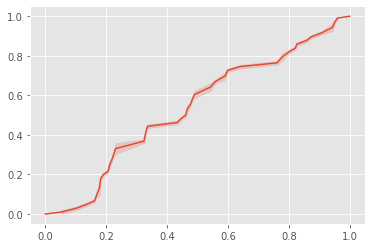

In [554]:
# Create the ROC curve and report AUC
yp_fm1 = fm1.predict_proba(Xtest)[:,1]
fpr1, tpr1, thresholds = roc_curve(ytest, yp_fm1 ,pos_label=1)
ax=sns.lineplot(fpr1,tpr1)
print('AUC value:',auc(fpr1,tpr1))

#3pts

The manager asks you if you advice the bank to continue using the baseline model. Why or why not?


**ANSWER HERE** \
I do not advice the bank to continuing using the baseline model. Because the resulting AUC is around 0.5, which is almost the worst possible. And graph shows almost a straight line, which is not a really fitting model. 
[2 pt] 


____________

### Question 4: /40

The manager wants you to determine the best single numeric feature model to predict the default status. You are asked to create a model per each numeric variable: `mortAcc`, `pub_rec_bankruptcies`,`Log_annAmnt` `revol_util`  , `emp_length` `revol_bal`,`dti`, `ratio_inst_inc`,`Log_annualInc`,`term`,             `int_rate`. He also advises you to use the cross-validation technique to make your decision. 


You remember that *cross-validation* is used to find the expected 
test error of the models. In addition, in the next code, 5 different folds are displayed using 5 fold cross-validation, using the `StratifiedKFold()` function.

Text(0.5, 1.0, 'Cross Validation ')

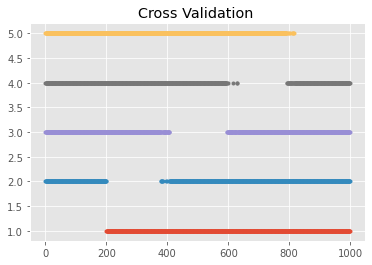

In [555]:
# code in which you remember cross-validation technique
str_kf = StratifiedKFold(n_splits=5)
for j, (index_train, index_test) in enumerate(str_kf.split(X,y)):
    plt.plot(index_train, [j+1 for s in index_train], '.')
plt.title('Cross Validation ')

#### 4.1: /5
**Define a function `AUC_calculation` with inputs `(X, y, index_train, index_test)`  which calculates the AUC of the `model1` trained on `index_train` and tested on `index_test`.**

In [556]:
def AUC_calculation(X, y, index_train, index_test):
    # Define Xtrain, ytrain, Xtest, ytest 
    Xtrain, ytrain = X[X.index.isin(index_train)] , y[y.index.isin(index_train)]
    Xtest, ytest = X[X.index.isin(index_test)] , y[y.index.isin(index_test)]
    Xtest.head()
    #fit the model and predict the default probabilities
    model = model1.fit(Xtrain,ytrain.values)
    ypre = model.predict_proba(Xtest)[:,1]
    
    # Calculate the auc score
    auc = roc_auc_score(ytest,ypre)
    return auc 
# 5 pts

#### 4.2: /8
**Using `AUC_calculation` create a function named `AUC_cross_validation` which has as input (X, y, n_fold). `AUC_cross_validation` does a `n_fold` cross validation (using `StratifiedKFold`). The function's output should be a list with the AUC for each fold.** 

In [557]:
def AUC_cross_validation(X, y, n_fold):
    # Create the stratified folds
    str_kf = StratifiedKFold(n_splits=n_fold)
    # list with the auc scores
    list_auc = []
    # hint: take as guide the code in which you remembered cross-validation technique
    for j,  (index_train, index_test) in enumerate(str_kf.split(X,y)):
        list_auc.append(AUC_calculation(X, y, index_train, index_test))
    
    return list_auc
# 8pts 

#### 4.3: /5
**Now you are ready to estimate and compare using cross validation the performance of all the *simple models* that only use one numeric predictor as input. Remember to use the logarithm transformation for the `annualInc` and  `loanAmnt` variables. You do not include `Year` and `installment` variables.**

In [558]:
# Extract from Data1 only the numeric features

Data1_num = Data1.select_dtypes(include=np.number)

# Transform the variables using logarithm function, name these new variables
# Log_annualInc and Log_annAmnt 
# Log_annualInc is done in question 2
Data1_num.insert(10,'Log_annAmnt', np.log(Data1_num['loanAmnt']))

# Eliminate the variables Year and installment,and the originals
# annualInc and loanAmnt
Data1_y = Data1_num['loanDefault']
Data1_num = Data1_num.drop(['annualInc','loanAmnt','Year','installment','loanDefault'],axis='columns')
Data1_num = pd.DataFrame(Data1_num)

# print the first 5 rows of Data1_num
Data1_num.head()

# 5pts

,int_rate,revol_bal,revol_util,dti,emp_length,mortAcc,Log_annAmnt,pub_rec_bankruptcies,term,ratio_inst_inc,Log_annualInc
993,14.31,55242.0,70.8,24.79,1,11,10.321375,0,36,0.083418,11.918391
859,18.85,5944.0,91.4,21.32,3,4,8.507143,0,36,0.127821,9.740969
298,16.49,7303.0,46.5,5.30,1,8,8.294050,0,36,0.041444,10.621327
553,9.67,13917.0,58.0,5.42,4,9,9.210340,0,36,0.059286,11.082143
672,16.29,10265.0,60.0,21.00,1,15,9.102198,0,36,0.126732,10.308953


#### 4.4: /8

**Use your function `AUC_cross_validation` to compute cross-validation estimates of the AUC for each single numeric feature model, use a data frame (named `AUC_models`) to report the AUC value for each fold and each of the models. (Use `n_fold=10`).**

**The column names of `AUC_models` have to be in the form `Simple-numeric predictor variable`, e.g `simple-int_rate`.**

In [559]:
# Construct AUC_models dataframe
n_fold = 10

AUC_models = pd.DataFrame()
for col_name in Data1_num.columns:
    AUC_models['simple-'+col_name] = AUC_cross_validation(Data1_num[[col_name]], Data1_y, n_fold)
    

#8 pts

In [560]:
# Print AUC_models dataframe 
AUC_models

,simple-int_rate,simple-revol_bal,simple-revol_util,simple-dti,simple-emp_length,simple-mortAcc,simple-Log_annAmnt,simple-pub_rec_bankruptcies,simple-term,simple-ratio_inst_inc,simple-Log_annualInc
0,0.723529,0.542745,0.573333,0.617647,0.473725,0.604706,0.405882,0.470588,0.621569,0.507451,0.705882
1,0.781875,0.567500,0.528125,0.503750,0.659375,0.484688,0.630937,0.500000,0.625000,0.587500,0.430000
2,0.613060,0.588044,0.496751,0.514620,0.459714,0.558804,0.449968,0.525016,0.571475,0.614035,0.713125
3,0.661130,0.534884,0.456811,0.693937,0.552741,0.503322,0.571013,0.518272,0.544020,0.738372,0.627492
4,0.534375,0.464375,0.494063,0.540000,0.533750,0.478125,0.473750,0.575000,0.550000,0.490000,0.517188
5,0.736287,0.658228,0.466546,0.498794,0.540084,0.521700,0.490356,0.495479,0.517782,0.480410,0.486739
6,0.739203,0.547342,0.711379,0.574751,0.474252,0.549419,0.597176,0.489203,0.579734,0.759136,0.661545
7,0.778103,0.449643,0.544834,0.501949,0.471085,0.523392,0.570500,0.482781,0.743340,0.478233,0.471735
8,0.616875,0.542500,0.575313,0.623125,0.586250,0.534375,0.474062,0.575000,0.606250,0.595000,0.627500
9,0.434089,0.532247,0.391566,0.572644,0.587881,0.463501,0.494685,0.469880,0.538625,0.462084,0.506378


In [561]:
# print the shape of AUC_models dataframe
AUC_models.shape

(10, 11)

#### 4.5: /7

**Decide which of the studied models has the best and the worst performance, using a boxplot (without presenting outliers) that shows the distribution of the previous AUC scores for every model.** (Again, do not forget labels!)

*The manager expects you to present a boxplot in which the means of the AUC scores are, organized ascending. Of course, you include the axis labels, and the name of each model should be clearly seen!*

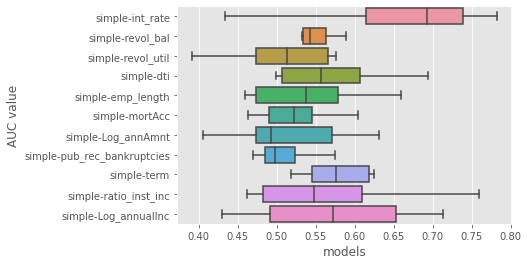

In [562]:
# Code to plot the boxplots organized as required

sns.set_palette('Set2')
sns.boxplot(x="value", y="variable", data=pd.melt(AUC_models),showfliers=False)
plt.xlabel('models')
plt.ylabel('AUC value')
plt.show()
#6 pts

**ANSWER HERE:**[1 pt] \
The model with int_rate seems to have the best performance since the majority auc result is around 0.6 and 0.7. The worst performance is the Log_annualamnt. It has the lowest median, which indicates that most data are sround 0.4 and 0.5. 


#### 4.6: /7
**The manager got surprised by your previous results! You are asked to compare these models with the one including all the numeric variables** 

**You again will use 10-fold cross-validation to determine if this new model has better performance, and at the end, you want to plot the boxplots with the information of this new model.**  

In [563]:

# Print the modified data frame 
AUC_models["All_numeric"] = AUC_cross_validation(Data1_num, Data1_y, n_fold)
AUC_models

# 4 pts 

,simple-int_rate,simple-revol_bal,simple-revol_util,simple-dti,simple-emp_length,simple-mortAcc,simple-Log_annAmnt,simple-pub_rec_bankruptcies,simple-term,simple-ratio_inst_inc,simple-Log_annualInc,All_numeric
0,0.723529,0.542745,0.573333,0.617647,0.473725,0.604706,0.405882,0.470588,0.621569,0.507451,0.705882,0.794510
1,0.781875,0.567500,0.528125,0.503750,0.659375,0.484688,0.630937,0.500000,0.625000,0.587500,0.430000,0.733750
2,0.613060,0.588044,0.496751,0.514620,0.459714,0.558804,0.449968,0.525016,0.571475,0.614035,0.713125,0.657570
3,0.661130,0.534884,0.456811,0.693937,0.552741,0.503322,0.571013,0.518272,0.544020,0.738372,0.627492,0.656977
4,0.534375,0.464375,0.494063,0.540000,0.533750,0.478125,0.473750,0.575000,0.550000,0.490000,0.517188,0.542500
5,0.736287,0.658228,0.466546,0.498794,0.540084,0.521700,0.490356,0.495479,0.517782,0.480410,0.486739,0.730561
6,0.739203,0.547342,0.711379,0.574751,0.474252,0.549419,0.597176,0.489203,0.579734,0.759136,0.661545,0.681063
7,0.778103,0.449643,0.544834,0.501949,0.471085,0.523392,0.570500,0.482781,0.743340,0.478233,0.471735,0.684860
8,0.616875,0.542500,0.575313,0.623125,0.586250,0.534375,0.474062,0.575000,0.606250,0.595000,0.627500,0.697500
9,0.434089,0.532247,0.391566,0.572644,0.587881,0.463501,0.494685,0.469880,0.538625,0.462084,0.506378,0.491850


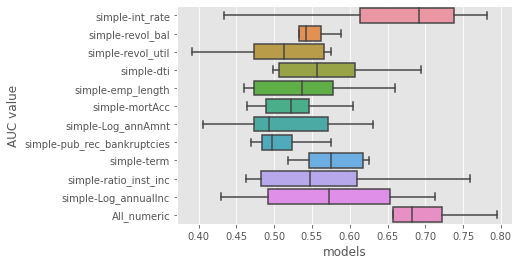

In [564]:
# Plot the boxplots
sns.boxplot(x="value", y="variable", data=pd.melt(AUC_models),showfliers=False)
plt.xlabel('models')
plt.ylabel('AUC value')
plt.show()

# 3pt

_____________

### Question 5: /10

Finally, the manager askes you to continue from `All_numeric` model and include some categorical variables that have not been used so far. You plan to do this in two steps:

1.First, add the variable `Grade` to the model.

In [565]:
# Use pandas.get_dummies() to incorporating grade, do not forget to use drop_first=True 
new = pd.get_dummies(Data1['grade'],drop_first=True )
# Add this feature to all the numeric variables
Data1_num_grade = pd.concat([Data1_num, new], axis=1)
# Calculate the auc scores using cross validation
score = AUC_cross_validation(Data1_num, Data1_y, n_fold)
# Include the auc scores in the AUC_models DataFrame in the column 'All_numeric_&_Grade'
AUC_models["All_numeric_&_Grade"] = score

In [566]:
# Print the AUC mean for each of the models in ascending order
AUC_models.mean(axis=0).sort_values()
# 4 pts

simple-pub_rec_bankruptcies    0.510122
simple-Log_annAmnt             0.515833
simple-mortAcc                 0.522203
simple-revol_util              0.523872
simple-emp_length              0.533886
simple-revol_bal               0.542751
simple-dti                     0.564122
simple-ratio_inst_inc          0.571222
simple-Log_annualInc           0.574758
simple-term                    0.589779
simple-int_rate                0.661853
All_numeric                    0.667114
All_numeric_&_Grade            0.667114
dtype: float64

2. Secondly add the `purpose` variable to the model `All_numeric_&_Grade`. 

In [567]:
# Use pandas.get_dummies() to incorporating job, do not forget to use drop_first=True 
new = pd.get_dummies(Data1['purpose'],drop_first=True )
# Add this feature to all the numeric variables
Data1_num_grade_pur = pd.concat([Data1_num, new], axis=1)
# Calculate the auc scores using cross validation
score = AUC_cross_validation(Data1_num, Data1_y, n_fold)
AUC_models["All_numeric_&_Grade_pur"] = score

In [568]:
# Print the AUC mean for each of the models in ascending order
AUC_models.mean(axis=0).sort_values()
#4 pts

simple-pub_rec_bankruptcies    0.510122
simple-Log_annAmnt             0.515833
simple-mortAcc                 0.522203
simple-revol_util              0.523872
simple-emp_length              0.533886
simple-revol_bal               0.542751
simple-dti                     0.564122
simple-ratio_inst_inc          0.571222
simple-Log_annualInc           0.574758
simple-term                    0.589779
simple-int_rate                0.661853
All_numeric                    0.667114
All_numeric_&_Grade            0.667114
All_numeric_&_Grade_pur        0.667114
dtype: float64

Because of your previous results, you decided to select the `All_numeric` model. Looking at your previous results, explain why you made this choice. 

**ANSWER HERE:**[2pt] \
When adding the dummy variables grade and purpose, the mean AUC score does not change at all. The model does not become better. In this case, therefore we choose the simpliest model all_numeric among three.


______________

### Question 6: /15pts

You've successfully convinced the manager to use the model you selected! Now it is time to train it on all the training data. Estimate the performance of this model on the test data and do the following (For this, use a 70/30 train-test split of the data, remember to set `random_state=0` in the function `train_test_split` ): 

- Use boostrap technique to find the 95% CI for the AUC. 
- Plot the distribution of the boostrap AUC scores.

In [569]:
Xtrain6, Xtest6, ytrain6, ytest6 = train_test_split(Data1_num,Data1_y,test_size=0.3,random_state=0)

#Fit the model
fm2 = model1.fit(Xtrain6,ytrain6)
#Calculate the predictions on the Test data
ypre6 = fm2.predict_proba(Xtest6)[:,1]
# Report AUC
auc_model6 = roc_auc_score(ytest6,ypre6)
print(f'The auc:',auc_model6)
# 1 pt

The auc: 0.7273699488197999


In [570]:
boostraps_num = 1200
boostraps_auc =[]
n = len(Data1_num)

np.random.RandomState(3)
for i in range(boostraps_num):
    index = np.random.choice(Data1_num.index,n,replace = True)
    Xtrain6, Xtest6, ytrain6, ytest6 = train_test_split(Data1_num[Data1_num.index.isin(index)],Data1_y[Data1_y.index.isin(index)],test_size=0.3,random_state=0)
    fm2 = model1.fit(Xtrain6,ytrain6)
    ypre6 = fm2.predict_proba(Xtest6)[:,1]
    score = roc_auc_score(ytest6,ypre6)
    boostraps_auc.insert(0,score)
# 5pts

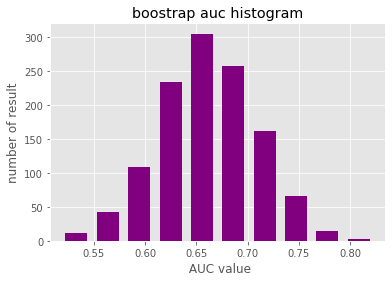

In [571]:
# Histogram of the boostrapped AUC scores
plt.hist(boostraps_auc, color='purple', rwidth=0.7)
plt.xlabel(' AUC value')
plt.ylabel('number of result')
plt.title('boostrap auc histogram')
plt.show()
# 3 pts

In [572]:
# Sort the samples
boostraps_auc.sort()

# Calculating the limits, this is the 0.025 and 0.975 percentiles of the Boostrap distribution 
diff = boostraps_auc - auc_model6
ci_min = auc_model6-np.percentile(diff,0.975)
ci_max = auc_model6-np.percentile(diff,0.025)
# 
print(f'The CI for the AUC of the model is: {(ci_min,ci_max) }')
# 5 pts

The CI for the AUC of the model is: (0.9032292392011303, 0.9342542911863463)


Is the test AUC close to the AUC cross validation of the model you chose? Why do you think this is the case? Answer below as if you were talking to the hiring manager.

**ANSWER HERE:**[1pt] \
The test AUC is not really close to the AUC cross validation. Because cross validation is biased. Cross validation has larger variance. Whereas CV is used to determine models and boostrap is used more when the model is fixed.  



Nicely done! You expect the best from this interview !!!